# README 프라이버시 보호를 위한 얼굴 부위 조합 딥페이크 생성기법
팀 교수님제주도에서는차긁으시면안됩니다  
이 파일은 캐글 기준에서 Deepfake Detection and Generation Challenge RED_TEAM 데이터셋을 사용하는 코드입니다.  
드롭박스 링크 : https://www.dropbox.com/scl/fo/gk62g964fwpqehil8dtr1/AC6wZi1NHsU9ZVP_tIF3ARU?rlkey=dium1k0z2k7zfa71s0vizxod4&st=d7e463ic&dl=0  
구글 드라이브 링크 : 결과 보고서, 딥페이크 파일, csv 파일 : https://drive.google.com/drive/folders/1FtjevDcXHJSRE3p9-ccUxFjRkmXG5hD2?usp=sharing

# **Step1: 원본 비디오에서 프레임 추출**

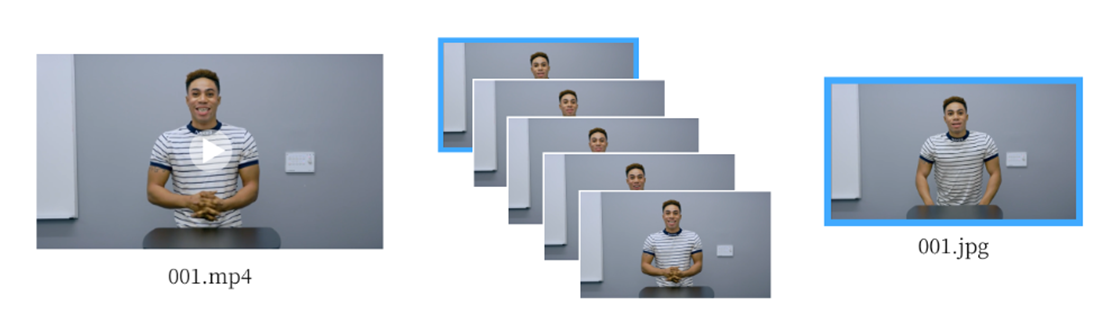

비디오에서 아래 조건을 만족한 프레임을 추출하여 저장합니다. (조건에 맞는 값이 없을 경우, 기준 완화)
- 정면을 보고 있음 (Yaw < 15도)
- 입이 거의 닫혀 있음 (입술 간 거리 < 임계값)
- 눈이 떠져 있음 (EAR > 임계값)


In [ ]:

!mkdir -p ~/.cache/torch/hub/checkpoints
!wget -O ~/.cache/torch/hub/checkpoints/s3fd-619a316812.pth \
  https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth

!wget -O ~/.cache/torch/hub/checkpoints/3DFAN4-4a694010b9.zip \
  https://www.adrianbulat.com/downloads/python-fan/3DFAN4-4a694010b9.zip

!pip install face-alignment imageio[ffmpeg] scikit-image

In [ ]:
import cv2
import os
import numpy as np
import torch
import face_alignment
from glob import glob

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"실행 장치: {device}")

fa = face_alignment.FaceAlignment("2D", device=device)

YAW_THRESHOLD = 15
MOUTH_THRESHOLD_1 = 5.0
EYE_THRESHOLD_1 = 0.3 

MOUTH_THRESHOLD_2 = 15
EYE_THRESHOLD_2 = 0.28

def get_landmarks(image):
    preds = fa.get_landmarks(image)
    return preds[0] if preds else None

def is_facing_forward(landmarks):
    left_eye = np.mean(landmarks[36:42], axis=0)
    right_eye = np.mean(landmarks[42:48], axis=0)
    dx = abs(left_eye[0] - right_eye[0])
    dy = abs(left_eye[1] - right_eye[1])
    yaw = np.degrees(np.arctan2(dy, dx))
    return yaw < YAW_THRESHOLD

def is_mouth_closed(landmarks, threshold):
    return abs(landmarks[62][1] - landmarks[66][1]) < threshold

def is_eye_open(landmarks, threshold):
    def ear(eye):
        v = np.linalg.norm(eye[1] - eye[5]) + np.linalg.norm(eye[2] - eye[4])
        h = 2.0 * np.linalg.norm(eye[0] - eye[3])
        return v / h
    le = ear(landmarks[36:42])
    re = ear(landmarks[42:48])
    return le > threshold and re > threshold  

def process_video(video_path, output_path, mouth_thres, eye_thres, retry=False):
    base = os.path.splitext(os.path.basename(video_path))[0]
    save_name = f"{base}.jpg"
    cap = cv2.VideoCapture(video_path)
    frame_num = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_num % 5 != 0:
            frame_num += 1
            continue

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        lm = get_landmarks(rgb)
        if lm is None:
            frame_num += 1
            continue

        if is_facing_forward(lm) and is_eye_open(lm, eye_thres) and is_mouth_closed(lm, mouth_thres):
            save_path = os.path.join(output_path, save_name)
            cv2.imwrite(save_path, frame)
            print(f"저장됨: {save_path}")
            cap.release()
            return True
        frame_num += 1

    cap.release()
    return False

if __name__ == "__main__":
    video_dir = "/kaggle/input/Deepfake_Detection_and_Generation_Challenge_Red_Team/Source_face_dataset"
    output_dir = "/kaggle/working/extracted_frames"
    os.makedirs(output_dir, exist_ok=True)

    failed = []
    videos = sorted(glob(os.path.join(video_dir, "*.mp4")))

    print(f"\n총 영상 수: {len(videos)}\n")

    for idx, path in enumerate(videos, 1):
        print(f"\n[{idx}/{len(videos)}] 처리 중: {os.path.basename(path)}")
        if not process_video(path, output_dir, MOUTH_THRESHOLD_1, EYE_THRESHOLD_1):
            failed.append(os.path.splitext(os.path.basename(path))[0])
            print("1차 조건 실패")

    if failed:
        print("\n2차 재처리 시작...")

        mouth_thres = MOUTH_THRESHOLD_2
        eye_thres = EYE_THRESHOLD_2
        max_mouth = 20
        min_eye = 0.2

        still_failed = failed[:]

        while still_failed and (mouth_thres <= max_mouth or eye_thres >= min_eye):
            print(f"\n현재 조건: 입 ≤ {mouth_thres}, 눈 EAR ≥ {eye_thres:.3f}")
            for f in still_failed[:]:
                path = os.path.join(video_dir, f + ".mp4")
                print(f"\n반복 재시도: {f}")
                if process_video(path, output_dir, mouth_thres, eye_thres, retry=True):
                    still_failed.remove(f)

            if mouth_thres < max_mouth:
                mouth_thres += 1
            if eye_thres > min_eye:
                eye_thres -= 0.01

        failed = still_failed

    print("\n참가 결과")
    if failed:
        print("실패한 비디오:")
        for f in failed:
            print(f" - {f}")
    else:
        print("프레임 추출 성공!")


# **Step 2: 추출한 이미지에서 얼굴 감지 및 정렬**

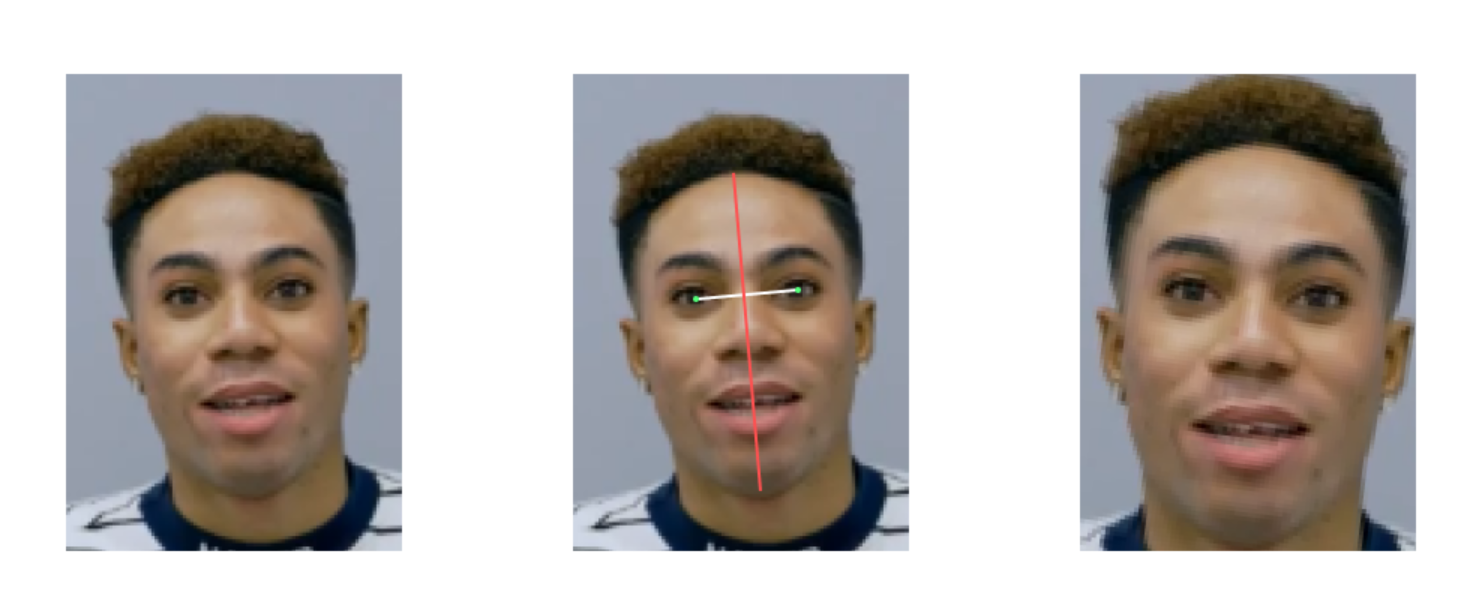

yolo를 사용하여 얼굴을 인식하고, dlib를 이용하여 눈 사이의 거리와
얼굴의 각도를 계산해 얼굴을 확대축소 하거나 회전합니다

In [ ]:

!pip install ultralytics dlib opencv-python-headless Pillow tqdm

!mkdir -p /kaggle/working/models

!wget -q http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 -P /kaggle/working/models
!bunzip2 /kaggle/working/models/shape_predictor_68_face_landmarks.dat.bz2

!wget -q https://github.com/akanametov/yolo-face/releases/download/v0.0.0/yolov8n-face.pt -P /kaggle/working/models

!ls -lh /kaggle/working/models



In [ ]:

!pip install facenet_pytorch

!pip install "pillow<10.0"


In [ ]:
import os
os._exit(0)

In [ ]:
import os
from glob import glob
from PIL import Image, ImageOps
import cv2
import numpy as np
from ultralytics import YOLO
import dlib
from tqdm import tqdm
from facenet_pytorch import MTCNN
import torch

# Configuration
frame_dir = "/kaggle/working/extracted_frames"
INPUT_DIR = frame_dir
CONVERTED_DIR = "/kaggle/working/3-1_extracted_frames_png"
ALIGNED_DIR = "/kaggle/working/3-2_aligned_faces"
PREDICTOR_PATH = "/kaggle/working/models/shape_predictor_68_face_landmarks.dat"
OUTPUT_SIZE = (256, 256)
CONF_THRESHOLD = 0.3
MAX_THUMBNAIL = 1024

# Ensure outputs exist
os.makedirs(CONVERTED_DIR, exist_ok=True)
os.makedirs(ALIGNED_DIR, exist_ok=True)

# Initialize models
yolo_model = YOLO("/kaggle/working/models/yolov8n-face.pt")
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)
mtcnn = MTCNN(image_size=256, margin=0, keep_all=False, device='cuda' if torch.cuda.is_available() else 'cpu')

def preprocess_jpg_to_png(jpg_path, png_path, max_size=MAX_THUMBNAIL):
    try:
        img = Image.open(jpg_path)
        img = ImageOps.exif_transpose(img).convert("RGB")
        img.thumbnail((max_size, max_size), Image.LANCZOS)
        img.save(png_path, "PNG", optimize=True)
        return True
    except Exception as e:
        print(f"변환 실패: {jpg_path}, error={e}")
        return False

def safe_imread(image_path):
    try:
        pil_img = Image.open(image_path).convert("RGB")
        img_array = np.array(pil_img)
        img = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
        if img.dtype != np.uint8:
            img = np.clip(img, 0, 255).astype(np.uint8)
        return img
    except Exception as e:
        print(f"이미지 읽기 실패: {image_path}, error={e}")
        return None

def align_face(image_path, output_dir, size=OUTPUT_SIZE, conf_thresh=CONF_THRESHOLD):
    img = safe_imread(image_path)
    if img is None:
        return False
    try:
        results = yolo_model(img, conf=conf_thresh, verbose=False)[0]
        boxes = results.boxes.xyxy.cpu().numpy().astype(int) if results.boxes else []
        if len(boxes) == 0:
            return False
        h, w = img.shape[:2]
        for box in sorted(boxes, key=lambda b: (b[2]-b[0])*(b[3]-b[1]), reverse=True):
            x1, y1, x2, y2 = box
            dx = int((x2 - x1) * 0.2)
            dy = int((y2 - y1) * 0.2)
            x1, y1, x2, y2 = max(0, x1 - dx), max(0, y1 - dy), min(w, x2 + dx), min(h, y2 + dy)
            roi = img[y1:y2, x1:x2]
            if roi.size == 0:
                continue
            roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            rects = detector(roi_gray, 1)
            if not rects:
                continue
            shape = predictor(roi_gray, rects[0])
            pts = np.array([[pt.x + x1, pt.y + y1] for pt in shape.parts()])
            left_eye = pts[36:42].mean(axis=0)
            right_eye = pts[42:48].mean(axis=0)
            eye_dist = np.linalg.norm(right_eye - left_eye)
            if eye_dist < 10:
                continue
            angle = np.degrees(np.arctan2(right_eye[1] - left_eye[1], right_eye[0] - left_eye[0]))
            eye_center = (left_eye + right_eye) / 2
            scale = (size[0] * 0.35) / eye_dist
            M = cv2.getRotationMatrix2D(tuple(eye_center), angle, scale)
            M[0,2] += size[0] * 0.5 - eye_center[0]
            M[1,2] += size[1] * 0.4 - eye_center[1]
            aligned = cv2.warpAffine(img, M, size, flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REFLECT)
            out_path = os.path.join(output_dir, os.path.splitext(os.path.basename(image_path))[0] + ".png")
            cv2.imwrite(out_path, aligned)
            return True
    except Exception as e:
        print(f"YOLO/dlib 실패: {image_path}, error={e}")
        return False
    return False

def align_with_mtcnn(image_path, output_dir):
    try:
        img = safe_imread(image_path)
        if img is None:
            return False
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        boxes, probs, landmarks = mtcnn.detect(img_rgb, landmarks=True)
        if boxes is None or len(boxes) == 0 or landmarks is None:
            return False

        idx = np.argmax([(box[2]-box[0])*(box[3]-box[1]) for box in boxes])
        lm = landmarks[idx]
        left_eye, right_eye = lm[0], lm[1]
        eye_dist = np.linalg.norm(right_eye - left_eye)
        if eye_dist < 10:
            return False

        angle = np.degrees(np.arctan2(right_eye[1] - left_eye[1], right_eye[0] - left_eye[0]))
        eye_center = (left_eye + right_eye) / 2
        scale = (OUTPUT_SIZE[0] * 0.35) / eye_dist

        M = cv2.getRotationMatrix2D(tuple(eye_center), angle, scale)
        M[0, 2] += OUTPUT_SIZE[0] * 0.5 - eye_center[0]
        M[1, 2] += OUTPUT_SIZE[1] * 0.4 - eye_center[1]

        aligned = cv2.warpAffine(img, M, OUTPUT_SIZE, flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REFLECT)

        out_path = os.path.join(output_dir, os.path.splitext(os.path.basename(image_path))[0] + ".png")
        cv2.imwrite(out_path, aligned)
        return True
    except Exception as e:
        print(f"MTCNN 정렬 실패: {image_path}, error={e}")
        return False

def main():
    jpg_files = glob(os.path.join(INPUT_DIR, '*.jpg'))
    print(f"{len(jpg_files)}개 JPG 변환 시작")
    for jpg in tqdm(jpg_files, desc='Converting JPG to PNG'):
        png_path = os.path.join(CONVERTED_DIR, os.path.splitext(os.path.basename(jpg))[0] + ".png")
        preprocess_jpg_to_png(jpg, png_path)

    png_files = glob(os.path.join(CONVERTED_DIR, '*.png'))
    if not png_files:
        print("PNG 파일 없음. JPG 변환을 먼저 확인하세요.")
        return

    success, failed_paths = 0, []
    print(f"총 {len(png_files)}개 이미지 정렬 시작")
    for png in tqdm(png_files, desc='Aligning faces (YOLO/dlib)'):
        if align_face(png, ALIGNED_DIR):
            success += 1
        else:
            failed_paths.append(png)

    mtcnn_success = 0
    if failed_paths:
        print(f"\n🔁 YOLO/dlib 실패 → MTCNN 처리 시도 ({len(failed_paths)}개)")
        for path in tqdm(failed_paths, desc="MTCNN fallback"):
            if align_with_mtcnn(path, ALIGNED_DIR):
                mtcnn_success += 1

    print(f"\n정렬 완료: YOLO/dlib={success}, MTCNN={mtcnn_success}, 실패={len(failed_paths)-mtcnn_success}")

if __name__ == "__main__":
    main()


## 이미지 전처리 2차 

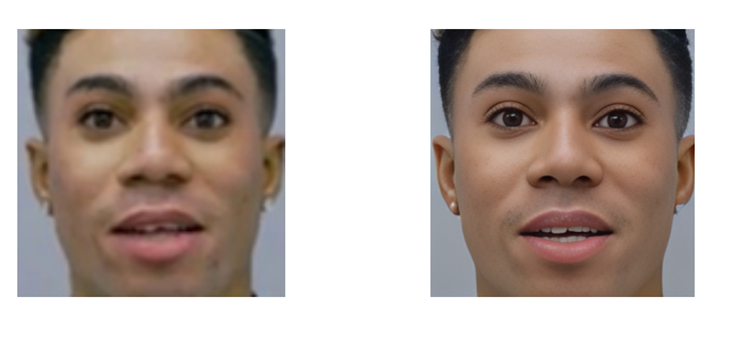

이미지를 고해상도로 전처리합니다

In [ ]:

%cd /kaggle/working

requirements = """\
torch==2.1.1
torchvision==0.16.1
tqdm==4.66.4
scipy==1.10.1
numpy==1.24.3
opencv-python==4.8.0.76
opencv-python-headless==4.8.0.76
imageio==2.35.1
Pillow==11.1.0
scikit-image==0.21.0
torch-fidelity==0.3.0
torchmetrics==1.4.1
timm==0.9.12
einops==0.7.0
clip==0.2.0
triton==2.1.0
safetensors==0.3.3
tokenizers==0.15.0
transformers==4.36.2
accelerate==0.23.0
diffusers==0.25.0
huggingface_hub==0.20.0
"""
file_path="requirements.txt"
with open(file_path, "w", encoding="utf-8") as f:
    f.write(requirements)
print(f"`{file_path}` has been overwritten with the new dependencies.")
!pip install --no-cache-dir --force-reinstall -r requirements.txt

!rm -rf GFPGAN
!git clone https://github.com/TencentARC/GFPGAN.git
%cd GFPGAN

!pip uninstall -y jax jaxlib transformers

requirements_content = """
basicsr==1.4.2
facexlib==0.3.0
lmdb
numpy==1.26.4
opencv-python
pyyaml
scipy
tb-nightly
torch==2.0.1
torchvision==0.15.2
tqdm
yapf
realesrgan==0.3.0
""".strip()

with open("requirements.txt", "w") as f:
    f.write(requirements_content)

!pip install -r requirements.txt
!python setup.py develop
!pip install realesrgan 

!wget https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth -P experiments/pretrained_models

%cd /kaggle/working/GFPGAN

In [ ]:
%cd /kaggle/working/GFPGAN

In [ ]:
!rm -rf results

!python inference_gfpgan.py \
  -i /kaggle/working/3-2_aligned_faces \
  -o /kaggle/working/3-3_aligned_GFPGANfacesp \
  -v 1.3 \
  -s 1 \
  --bg_upsampler none


# **Step 3: 피부톤 변경 및 얼굴 배치**

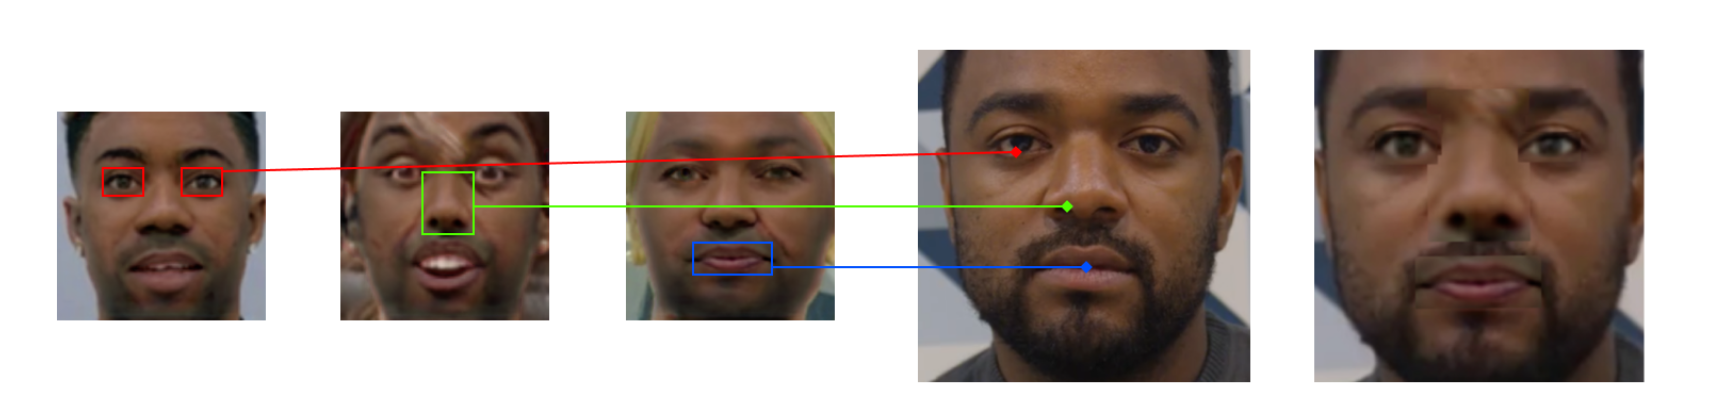

눈, 코, 입을 추출할 서로 다른 3개의 소스 이미지를 MTCNN를 이용해 베이스 이미지의 피부 색상으로 변경한 후, 
yolo를 이용해 각 이미지에서 눈, 코, 입을 추출해 베이스 이미지에 배치합니다

In [ ]:
%%bash
set -e

cd /kaggle/working/models

WEIGHT_URL="https://github.com/ignaciohrdz/yolo-face-parts-detector/releases/download/v2.0.0/yolov8m.pt"
WEIGHT_PATH="yolov8m-face-parts.pt"

if [ ! -f "$WEIGHT_PATH" ]; then
  echo "⏬ Downloading face-parts model from:"
  echo "   $WEIGHT_URL"
  wget -q -L --show-progress "$WEIGHT_URL" -O "$WEIGHT_PATH"
  echo "✅ Download complete: $WEIGHT_PATH"
else
  echo "✔️ $WEIGHT_PATH already exists, skipping"
fi



In [ ]:

%cd /kaggle/working
!git clone https://github.com/Snowfallingplum/CSD-MT
import os
os.chdir('/kaggle/working/CSD-MT/quick_start')

!pip install -U gdown

!mkdir -p faceutils/dlibutils
!mkdir -p faceutils/face_parsing/res/cp
!mkdir -p CSD_MT/weights

!gdown --id 1fcraLr1mGYLwtDUFdanYC4aqxKA971JH -O faceutils/dlibutils/lms.dat
!gdown --id 1tTKxzcEHrtJVEoJonCucAD4nXUPRu4Wl -O CSD_MT/weights/CSD_MT.pth
!gdown --id 1V2EKuDlC7S6IR2NSrOcw8Cv50-vIUd5V -O faceutils/face_parsing/res/cp/79999_iter.pth

file_path = 'CSD_MT/options.py'

with open(file_path, 'r') as f:
    lines = f.readlines()

new_parse_function = [
    '    def parse(self, args=None):\n',
    '        if args is None:\n',
    '            self.opt, _ = self.parser.parse_known_args()\n',
    '        else:\n',
    '            self.opt = self.parser.parse_args(args)\n',
    '\n',
    '        args_dict = vars(self.opt)\n',
    '        print(\'\\n--- load options ---\')\n',
    '        for name, value in sorted(args_dict.items()):\n',
    '            print(f\'{name}: {value}\')\n',
    '        return self.opt\n'
]

with open(file_path, 'w') as f:
    inside_parse = False
    for line in lines:
        if line.strip().startswith('def parse('):
            inside_parse = True
            f.writelines(new_parse_function)
        elif inside_parse:
            if line.startswith('    def ') and not line.strip().startswith('def parse('):
                inside_parse = False
                f.write(line)
        elif not inside_parse:
            f.write(line)



!pip -q install supervision 


!cd /kaggle/working/CSD-MT/quick_start


print("CSD-MT 설정 완료!")





In [ ]:
!cd /kaggle/working/CSD-MT/quick_start

In [ ]:

import os
import cv2
import numpy as np
import random
from glob import glob
from ultralytics import YOLO
from tqdm import tqdm
from functools import lru_cache
import torch
from PIL import Image

from facenet_pytorch import MTCNN

import CSD_MT_eval

INPUT_DIR = "/kaggle/working/3-3_aligned_GFPGANfacesp/restored_imgs"
OUTPUT_DIR = "/kaggle/working/5_random_composites_with_makeup"
PARTS_MODEL = "/kaggle/working/models/yolov8m-face-parts.pt"
os.makedirs(OUTPUT_DIR, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn_detector = MTCNN(keep_all=True, device=device)

def load_and_validate_image(path):
    try:
        img = cv2.imread(path)
        if img is None:
            return None
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img_rgb.dtype == object:
            img_rgb = np.asarray(img_rgb, dtype=np.uint8)
        if len(img_rgb.shape) != 3 or img_rgb.shape[2] != 3:
            return None
        return img_rgb
    except:
        return None

paths = sorted(glob(os.path.join(INPUT_DIR, "*.png")))
images, valid_paths = [], []
for path in tqdm(paths, desc="Loading"):
    img = load_and_validate_image(path)
    if img is not None:
        images.append(img)
        valid_paths.append(path)
paths = valid_paths

yolo = YOLO(PARTS_MODEL)
CLS2NAME = {0: "eyes", 1: "nose", 2: "mouth", 3: "eyebrow"}

def detect_parts_yolo(img, conf=0.05):
    try:
        r = yolo(img, imgsz=640, conf=conf, iou=0.3, verbose=False)[0]
        boxes = r.boxes.xyxy.cpu().numpy().astype(int)
        clss = r.boxes.cls.cpu().numpy().astype(int)
        parts = {"eyes": [], "nose": [], "mouth": [], "eyebrow": []}
        for b, c in zip(boxes, clss):
            if c in CLS2NAME:
                parts[CLS2NAME[c]].append(b.tolist())
        return parts
    except:
        return {"eyes": [], "nose": [], "mouth": [], "eyebrow": []}

def detect_parts_mtcnn(img):
    try:
        pil_img = Image.fromarray(img)
        boxes, probs, landmarks = mtcnn_detector.detect(pil_img, landmarks=True)
        parts = {"eyes": [], "nose": [], "mouth": [], "eyebrow": []}
        if boxes is not None and landmarks is not None:
            best_idx = torch.argmax(torch.tensor(probs)).item()
            lms = landmarks[best_idx]
            h, w = img.shape[:2]
            eye_w, eye_h = int(w * 0.06), int(h * 0.04)
            nose_w, nose_h = int(w * 0.08), int(h * 0.12)
            mouth_w, mouth_h = int(abs(lms[4][0] - lms[3][0]) * 1.2), int(h * 0.08)
            for eye in [lms[0], lms[1]]:
                parts["eyes"].append([max(0, int(eye[0] - eye_w // 2)), max(0, int(eye[1] - eye_h // 2)), min(w, int(eye[0] + eye_w // 2)), min(h, int(eye[1] + eye_h // 2))])
            nose = lms[2]
            parts["nose"].append([max(0, int(nose[0] - nose_w // 2)), max(0, int(nose[1] - nose_h // 2)), min(w, int(nose[0] + nose_w // 2)), min(h, int(nose[1] + nose_h // 2))])
            mx = (lms[3][0] + lms[4][0]) / 2
            my = (lms[3][1] + lms[4][1]) / 2
            parts["mouth"].append([max(0, int(mx - mouth_w // 2)), max(0, int(my - mouth_h // 2)), min(w, int(mx + mouth_w // 2)), min(h, int(my + mouth_h // 2))])
        return parts
    except:
        return {"eyes": [], "nose": [], "mouth": [], "eyebrow": []}

def detect_parts(img):
    parts = detect_parts_yolo(img, conf=0.05)
    if len(parts["eyes"]) < 2 or not parts["nose"] or not parts["mouth"]:
        parts = detect_parts_yolo(img, conf=0.01)
    if len(parts["eyes"]) < 2 or not parts["nose"] or not parts["mouth"]:
        mtcnn_parts = detect_parts_mtcnn(img)
        for k in parts:
            if not parts[k]:
                parts[k] = mtcnn_parts[k]
    return parts

@lru_cache(maxsize=None)
def makeup(src_i, ref_i):
    try:
        out = CSD_MT_eval.makeup_transfer256(images[src_i], images[ref_i])
    except (ValueError, Exception):
        return None
    if out is None:
        return None
    if out.dtype == object:
        print(f"Warning: Makeup output has object dtype, converting to uint8")
        out = np.asarray(out, dtype=np.uint8)
    elif out.dtype != np.uint8:
        out = (np.clip(out,0,1)*255).astype("uint8")
    return out


def paste(src, sb, dst, db):
    try:
        patch = src[sb[1]:sb[3], sb[0]:sb[2]]
        if patch.size == 0:
            return dst
        patch_resized = cv2.resize(patch, (db[2]-db[0], db[3]-db[1]))
        dst_roi = dst[db[1]:db[3], db[0]:db[2]]
        if dst_roi.size == 0:
            return dst
        src_mean = patch_resized.mean(axis=(0, 1))
        dst_mean = dst_roi.mean(axis=(0, 1))
        diff = dst_mean - src_mean
        patch_adjusted = np.clip(patch_resized + diff, 0, 255).astype(np.uint8)
        dst[db[1]:db[3], db[0]:db[2]] = patch_adjusted
    except Exception as e:
        print(f"⚠️ paste error: {e}")
    return dst

def get_valid_donor(part_name, face_idx):
    candidates = list(range(len(images)))
    random.shuffle(candidates)
    for donor_idx in candidates:
        if donor_idx == face_idx:
            continue
        parts = detect_parts(images[donor_idx])
        if len(parts[part_name]) >= (2 if part_name == "eyes" else 1):
            return donor_idx, parts
    return None, None

failed_ids = set()
successful_count = 0

for i, face in enumerate(tqdm(images, desc="Composites")):
    d_face = detect_parts(face)
    if len(d_face["eyes"]) < 2 or not d_face["nose"] or not d_face["mouth"]:
        failed_ids.add(paths[i])
        continue

    donor_info = {}
    for part in ["eyes", "nose", "mouth"]:
        donor, donor_parts = get_valid_donor(part, i)
        donor_info[part] = (donor, donor_parts) if donor is not None else None

    if any(v is None for v in donor_info.values()):
        failed_ids.add(paths[i])
        continue

    out = makeup(i, donor_info['eyes'][0])
    if out is None:
        out = face.copy()

    for part in ["nose", "eyes", "mouth"]:
        donor_idx, d_parts = donor_info[part]
        mk = images[donor_idx]
        tgt_boxes = sorted(d_face[part], key=lambda b: b[0])[:2] if part == "eyes" else [d_face[part][0]]
        src_boxes = sorted(d_parts[part], key=lambda b: b[0])[:2] if part == "eyes" else [d_parts[part][0]]
        for sb, db in zip(src_boxes, tgt_boxes):
            out = paste(mk, sb, out, db)

    face_main = os.path.splitext(os.path.basename(paths[i]))[0].split("_")[0]
    eyes_main = os.path.splitext(os.path.basename(paths[donor_info['eyes'][0]]))[0].split("_")[0]
    nose_main = os.path.splitext(os.path.basename(paths[donor_info['nose'][0]]))[0].split("_")[0]
    mouth_main = os.path.splitext(os.path.basename(paths[donor_info['mouth'][0]]))[0].split("_")[0]

    out_name = f"{face_main}_{eyes_main}_{nose_main}_{mouth_main}.png"
    cv2.imwrite(os.path.join(OUTPUT_DIR, out_name), cv2.cvtColor(out, cv2.COLOR_RGB2BGR))
    successful_count += 1

print(f"\n성공: {successful_count}, 실패: {len(failed_ids)}")
if failed_ids:
    print("\n실패한 이미지 목록:")
    for fid in failed_ids:
        print("-", os.path.basename(fid))


#  실패한 이미지들 처리 

In [ ]:
# gan 세팅 하기 
%cd /kaggle/working

requirements = """\
torch==2.1.1
torchvision==0.16.1
tqdm==4.66.4
scipy==1.10.1
numpy==1.24.3
opencv-python==4.8.0.76
opencv-python-headless==4.8.0.76
imageio==2.35.1
Pillow==11.1.0
scikit-image==0.21.0
torch-fidelity==0.3.0
torchmetrics==1.4.1
timm==0.9.12
einops==0.7.0
clip==0.2.0
triton==2.1.0
safetensors==0.3.3
tokenizers==0.15.0
transformers==4.36.2
accelerate==0.23.0
diffusers==0.25.0
huggingface_hub==0.20.0
"""
file_path="requirements.txt"
with open(file_path, "w", encoding="utf-8") as f:
    f.write(requirements)
print(f"`{file_path}` has been overwritten with the new dependencies.")
!pip install --no-cache-dir --force-reinstall -r requirements.txt

!rm -rf GFPGAN
!git clone https://github.com/TencentARC/GFPGAN.git
%cd GFPGAN

!pip uninstall -y jax jaxlib transformers

requirements_content = """
basicsr==1.4.2
facexlib==0.3.0
lmdb
numpy==1.26.4
opencv-python
pyyaml
scipy
tb-nightly
torch==2.0.1
torchvision==0.15.2
tqdm
yapf
realesrgan==0.3.0
""".strip()

with open("requirements.txt", "w") as f:
    f.write(requirements_content)

!pip install -r requirements.txt
!python setup.py develop
!pip install realesrgan 

!wget https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth -P experiments/pretrained_models

%cd /kaggle/working/GFPGAN

# 얼굴 정렬  (합성 실패 이미지 -> gan 화질 복원 ->  얼굴 정렬) 

In [ ]:
for img_path in failed_ids:
    command = f"""
    python inference_gfpgan.py \
        -i "{img_path}" \
        -o /kaggle/working/5_failed_img_gfpgan \
        -v 1.3 \
        -s 1 \
        --bg_upsampler none
    """
    os.system(command)

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
from PIL import Image
from ultralytics import YOLO
import dlib
from facenet_pytorch import MTCNN
import torch

INPUT_DIR = "/kaggle/working/5_failed_img_gfpgan/restored_imgs"
ALIGNED_DIR = "/kaggle/working/5_failed_img_aligned_faces"
PREDICTOR_PATH = "/kaggle/working/models/shape_predictor_68_face_landmarks.dat"
OUTPUT_SIZE = (256, 256)
CONF_THRESHOLD = 0.3
MIN_EYE_DIST = 30 
os.makedirs(ALIGNED_DIR, exist_ok=True)

yolo_model = YOLO("/kaggle/working/models/yolov8n-face.pt")
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)
mtcnn = MTCNN(image_size=256, margin=0, keep_all=False, device='cuda' if torch.cuda.is_available() else 'cpu')

def safe_imread(image_path):
    try:
        pil_img = Image.open(image_path).convert("RGB")
        img = np.array(pil_img)
        return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    except:
        return None

def center_crop_resize(img, size=(256, 256)):
    h, w = img.shape[:2]
    min_dim = min(h, w)
    start_x = (w - min_dim) // 2
    start_y = (h - min_dim) // 2
    cropped = img[start_y:start_y+min_dim, start_x:start_x+min_dim]
    return cv2.resize(cropped, size, interpolation=cv2.INTER_CUBIC)

def align_face(image_path, output_dir):
    img = safe_imread(image_path)
    if img is None:
        return False
    try:
        results = yolo_model(img, conf=CONF_THRESHOLD, verbose=False)[0]
        boxes = results.boxes.xyxy.cpu().numpy().astype(int) if results.boxes else []
        if len(boxes) == 0:
            return False

        h, w = img.shape[:2]
        for box in sorted(boxes, key=lambda b: (b[2]-b[0])*(b[3]-b[1]), reverse=True):
            x1, y1, x2, y2 = box
            dx, dy = int((x2-x1)*0.2), int((y2-y1)*0.2)
            x1, y1 = max(0, x1-dx), max(0, y1-dy)
            x2, y2 = min(w, x2+dx), min(h, y2+dy)
            roi = img[y1:y2, x1:x2]
            if roi.size == 0:
                continue
            shape = predictor(cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY), detector(roi, 1)[0])
            pts = np.array([[pt.x + x1, pt.y + y1] for pt in shape.parts()])
            left_eye, right_eye = pts[36:42].mean(axis=0), pts[42:48].mean(axis=0)
            eye_dist = np.linalg.norm(right_eye - left_eye)
            if eye_dist < MIN_EYE_DIST:
                continue

            angle = np.degrees(np.arctan2(right_eye[1] - left_eye[1], right_eye[0] - left_eye[0]))
            eye_center = (left_eye + right_eye) / 2
            scale = (OUTPUT_SIZE[0] * 0.35) / eye_dist
            M = cv2.getRotationMatrix2D(tuple(eye_center), angle, scale)
            M[0,2] += OUTPUT_SIZE[0]*0.5 - eye_center[0]
            M[1,2] += OUTPUT_SIZE[1]*0.4 - eye_center[1]
            aligned = cv2.warpAffine(img, M, OUTPUT_SIZE, flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REFLECT)
            out_path = os.path.join(output_dir, os.path.splitext(os.path.basename(image_path))[0] + ".png")
            cv2.imwrite(out_path, aligned)
            return True
    except:
        return False
    return False

def align_with_mtcnn(image_path, output_dir):
    img = safe_imread(image_path)
    if img is None:
        return False
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    boxes, probs, landmarks = mtcnn.detect(img_rgb, landmarks=True)
    if boxes is None or len(boxes) == 0 or landmarks is None:
        return False

    idx = np.argmax([(b[2]-b[0])*(b[3]-b[1]) for b in boxes])
    lm = landmarks[idx]
    left_eye, right_eye = lm[0], lm[1]
    eye_dist = np.linalg.norm(right_eye - left_eye)
    if eye_dist < MIN_EYE_DIST:
        return False

    angle = np.degrees(np.arctan2(right_eye[1] - left_eye[1], right_eye[0] - left_eye[0]))
    eye_center = (left_eye + right_eye) / 2
    scale = (OUTPUT_SIZE[0] * 0.35) / eye_dist
    M = cv2.getRotationMatrix2D(tuple(eye_center), angle, scale)
    M[0,2] += OUTPUT_SIZE[0]*0.5 - eye_center[0]
    M[1,2] += OUTPUT_SIZE[1]*0.4 - eye_center[1]
    aligned = cv2.warpAffine(img, M, OUTPUT_SIZE, flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REFLECT)
    out_path = os.path.join(output_dir, os.path.splitext(os.path.basename(image_path))[0] + ".png")
    cv2.imwrite(out_path, aligned)
    return True

def main():
    input_files = glob(os.path.join(INPUT_DIR, "*.*"))
    print(f"{len(input_files)}개 이미지 정렬 시도")

    yolo_success, mtcnn_success, fallback_crop = 0, 0, 0
    for path in tqdm(input_files, desc="Aligning"):
        if align_face(path, ALIGNED_DIR):
            yolo_success += 1
        elif align_with_mtcnn(path, ALIGNED_DIR):
            mtcnn_success += 1
        else:
            img = safe_imread(path)
            if img is not None:
                aligned = center_crop_resize(img, OUTPUT_SIZE)
                out_path = os.path.join(ALIGNED_DIR, os.path.splitext(os.path.basename(path))[0] + ".png")
                cv2.imwrite(out_path, aligned)
                fallback_crop += 1

    print(f"\n결과: YOLO/dlib={yolo_success}, MTCNN={mtcnn_success}, 중앙 crop={fallback_crop}, 총={len(input_files)}")

if __name__ == "__main__":
    main()


In [ ]:
import os
import cv2
import numpy as np
import random
from glob import glob
from ultralytics import YOLO
from tqdm import tqdm
from functools import lru_cache
import torch
from PIL import Image
from facenet_pytorch import MTCNN
import CSD_MT_eval

FACE_INPUT_DIR = "/kaggle/working/5_failed_img_aligned_faces"  
PARTS_INPUT_DIR = "/kaggle/working/3-2_aligned_faces"       
OUTPUT_DIR = "/kaggle/working/5_random_composites_with_makeup"
PARTS_MODEL = "/kaggle/working/models/yolov8m-face-parts.pt"
os.makedirs(OUTPUT_DIR, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn_detector = MTCNN(keep_all=True, device=device)
yolo = YOLO(PARTS_MODEL)
CLS2NAME = {0: "eyes", 1: "nose", 2: "mouth", 3: "eyebrow"}

def load_and_validate_image(path):
    try:
        img = cv2.imread(path)
        if img is None:
            return None
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img_rgb if img_rgb.shape[2] == 3 else None
    except:
        return None

def detect_parts_yolo(img, conf=0.05):
    try:
        r = yolo(img, imgsz=640, conf=conf, iou=0.3, verbose=False)[0]
        boxes = r.boxes.xyxy.cpu().numpy().astype(int)
        clss = r.boxes.cls.cpu().numpy().astype(int)
        parts = {k: [] for k in CLS2NAME.values()}
        for b, c in zip(boxes, clss):
            if c in CLS2NAME:
                parts[CLS2NAME[c]].append(b.tolist())
        return parts
    except:
        return {k: [] for k in CLS2NAME.values()}

def detect_parts_mtcnn(img):
    parts = {k: [] for k in CLS2NAME.values()}
    try:
        pil_img = Image.fromarray(img)
        boxes, probs, landmarks = mtcnn_detector.detect(pil_img, landmarks=True)
        if boxes is None or landmarks is None:
            return parts
        idx = np.argmax(probs)
        lms = landmarks[idx]
        h, w = img.shape[:2]
        eye_w, eye_h = int(w * 0.06), int(h * 0.04)
        nose_w, nose_h = int(w * 0.08), int(h * 0.12)
        mouth_w, mouth_h = int(abs(lms[4][0] - lms[3][0]) * 1.2), int(h * 0.08)
        for eye in [lms[0], lms[1]]:
            parts["eyes"].append([int(eye[0]-eye_w//2), int(eye[1]-eye_h//2), int(eye[0]+eye_w//2), int(eye[1]+eye_h//2)])
        nose = lms[2]
        parts["nose"].append([int(nose[0]-nose_w//2), int(nose[1]-nose_h//2), int(nose[0]+nose_w//2), int(nose[1]+nose_h//2)])
        mx = (lms[3][0] + lms[4][0]) / 2
        my = (lms[3][1] + lms[4][1]) / 2
        parts["mouth"].append([int(mx - mouth_w//2), int(my - mouth_h//2), int(mx + mouth_w//2), int(my + mouth_h//2)])
    except:
        pass
    return parts

def detect_parts(img):
    parts = detect_parts_yolo(img, conf=0.05)
    if len(parts["eyes"]) < 2 or not parts["nose"] or not parts["mouth"]:
        parts = detect_parts_yolo(img, conf=0.01)
    if len(parts["eyes"]) < 2 or not parts["nose"] or not parts["mouth"]:
        mtcnn_parts = detect_parts_mtcnn(img)
        for k in parts:
            if not parts[k]:
                parts[k] = mtcnn_parts[k]
    return parts

@lru_cache(maxsize=None)
def makeup(src_i, ref_i):
    try:
        out = CSD_MT_eval.makeup_transfer256(face_images[src_i], donor_images[ref_i])
        if out is None:
            return None
        if out.dtype != np.uint8:
            out = (np.clip(out, 0, 1) * 255).astype(np.uint8)
        return out
    except:
        return None

def paste(src, sb, dst, db):
    try:
        patch = src[sb[1]:sb[3], sb[0]:sb[2]]
        if patch.size == 0:
            return dst
        patch_resized = cv2.resize(patch, (db[2]-db[0], db[3]-db[1]))
        dst_roi = dst[db[1]:db[3], db[0]:db[2]]
        if dst_roi.size == 0:
            return dst
        src_mean = patch_resized.mean(axis=(0, 1))
        dst_mean = dst_roi.mean(axis=(0, 1))
        diff = dst_mean - src_mean
        patch_adjusted = np.clip(patch_resized + diff, 0, 255).astype(np.uint8)
        dst[db[1]:db[3], db[0]:db[2]] = patch_adjusted
    except Exception as e:
        print(f"error: {e}")
    return dst


def get_valid_donor(part_name):
    candidates = list(range(len(donor_images)))
    random.shuffle(candidates)
    for idx in candidates:
        parts = detect_parts(donor_images[idx])
        if len(parts[part_name]) >= (2 if part_name == "eyes" else 1):
            return idx, parts
    return None, None

face_paths = sorted(glob(os.path.join(FACE_INPUT_DIR, "*.png")))
face_images, valid_face_paths = [], []
for path in tqdm(face_paths, desc="Loading target faces"):
    img = load_and_validate_image(path)
    if img is not None:
        face_images.append(img)
        valid_face_paths.append(path)
face_paths = valid_face_paths

donor_paths = sorted(glob(os.path.join(PARTS_INPUT_DIR, "*.png")))
donor_images = []
for path in tqdm(donor_paths, desc="Loading donor faces"):
    img = load_and_validate_image(path)
    if img is not None:
        donor_images.append(img)

failed_ids = set()
success_count = 0

for i, face in enumerate(tqdm(face_images, desc="Composites")):
    d_face = detect_parts(face)
    if len(d_face["eyes"]) < 2 or not d_face["nose"] or not d_face["mouth"]:
        failed_ids.add(face_paths[i])
        continue

    donor_info = {}
    for part in ["eyes", "nose", "mouth"]:
        donor_idx, donor_parts = get_valid_donor(part)
        if donor_idx is None:
            donor_info[part] = None
        else:
            donor_info[part] = (donor_idx, donor_parts)

    if any(v is None for v in donor_info.values()):
        failed_ids.add(face_paths[i])
        continue

    out = makeup(i, donor_info['eyes'][0])
    if out is None:
        out = face.copy()

    for part in ["nose", "eyes", "mouth"]:
        donor_idx, d_parts = donor_info[part]
        src_img = donor_images[donor_idx]
        tgt_boxes = sorted(d_face[part], key=lambda b: b[0])[:2] if part == "eyes" else [d_face[part][0]]
        src_boxes = sorted(d_parts[part], key=lambda b: b[0])[:2] if part == "eyes" else [d_parts[part][0]]
        for sb, db in zip(src_boxes, tgt_boxes):
            out = paste(src_img, sb, out, db)

    face_main = os.path.splitext(os.path.basename(face_paths[i]))[0].split("_")[0]
    eyes_main = os.path.splitext(os.path.basename(donor_paths[donor_info['eyes'][0]]))[0].split("_")[0]
    nose_main = os.path.splitext(os.path.basename(donor_paths[donor_info['nose'][0]]))[0].split("_")[0]
    mouth_main = os.path.splitext(os.path.basename(donor_paths[donor_info['mouth'][0]]))[0].split("_")[0]

    out_name = f"{face_main}_{eyes_main}_{nose_main}_{mouth_main}.png"
    cv2.imwrite(os.path.join(OUTPUT_DIR, out_name), cv2.cvtColor(out, cv2.COLOR_RGB2BGR))
    success_count += 1

print(f"\n합성 완료: 성공 {success_count}개, 실패 {len(failed_ids)}개")
if failed_ids:
    print("실패한 이미지 목록:")
    for fid in failed_ids:
        print("-", os.path.basename(fid))


# **Step 4: GFPGAN를 이용하여 이미지 정제**

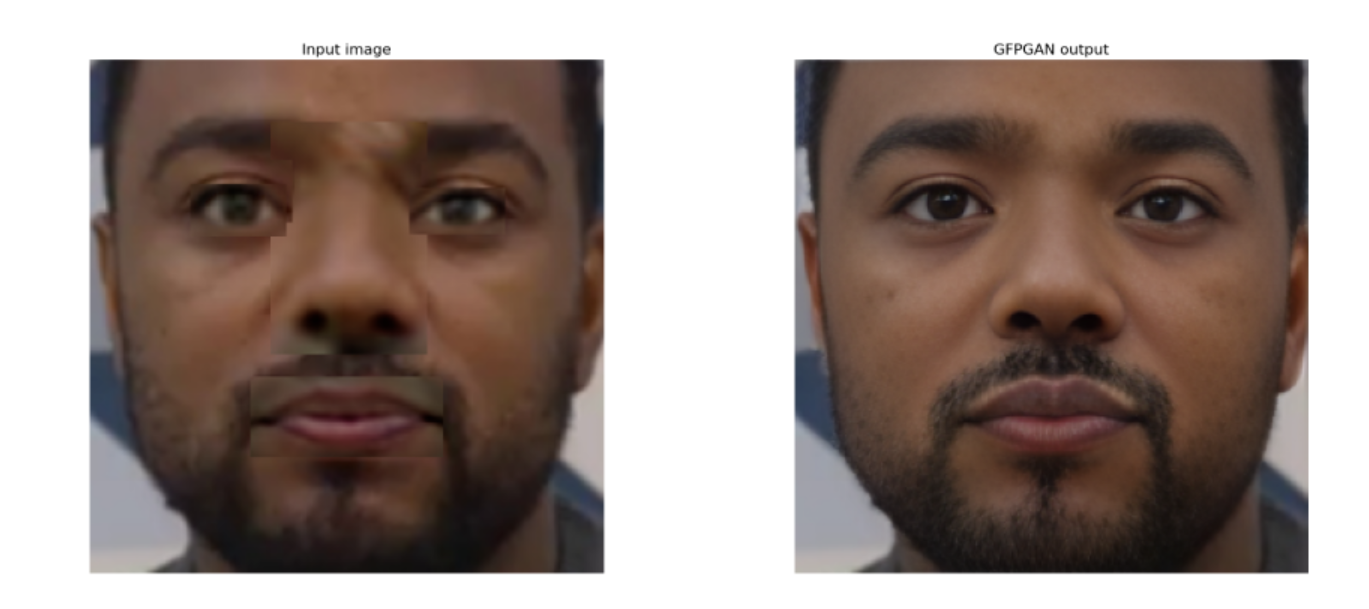

GFPGAN을 이용해 배치한 이미지를 정제합니다

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

def show_images_from_dir(directory, max_images=12, cols=4, figsize=(15, 10)):
    image_paths = sorted([os.path.join(directory, f) for f in os.listdir(directory)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))])[:max_images]
    rows = int(np.ceil(len(image_paths) / cols))
    plt.figure(figsize=figsize)
    for i, path in enumerate(image_paths):
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(os.path.basename(path), fontsize=9)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
show_images_from_dir("/kaggle/working/5_failed_img_aligned_faces", max_images=16)


# GFPGAN

In [ ]:
# Now we use the GFPGAN to restore the above low-quality images
# We use [Real-ESRGAN](https://github.com/xinntao/Real-ESRGAN) for enhancing the background (non-face) regions
# You can find the different models in https://github.com/TencentARC/GFPGAN#european_castle-model-zoo

!rm -rf results

!python inference_gfpgan.py \
  -i /kaggle/working/5_random_composites_with_makeup \
  -o /kaggle/working/6_GFPGAN_res \
  -v 1.3 \
  -s 1 \
  --bg_upsampler none

!ls /kaggle/working/6_GFPGAN_res

In [ ]:
import shutil
import os

# 압축 대상 경로와 출력 경로 설정
folder_to_zip = "/kaggle/working/6_GFPGAN_res/restored_imgs"
zip_output_path = "/kaggle/working/result_face_fusion.zip"

# 압축 실행
shutil.make_archive(zip_output_path.replace(".zip", ""), 'zip', folder_to_zip)

# 확인
if os.path.exists(zip_output_path):
    print("압축 완료:", zip_output_path)
else:
    print("압축 실패")

# **Step 5: inswapper를 이용해 비디오 속 사람의 얼굴 교체**

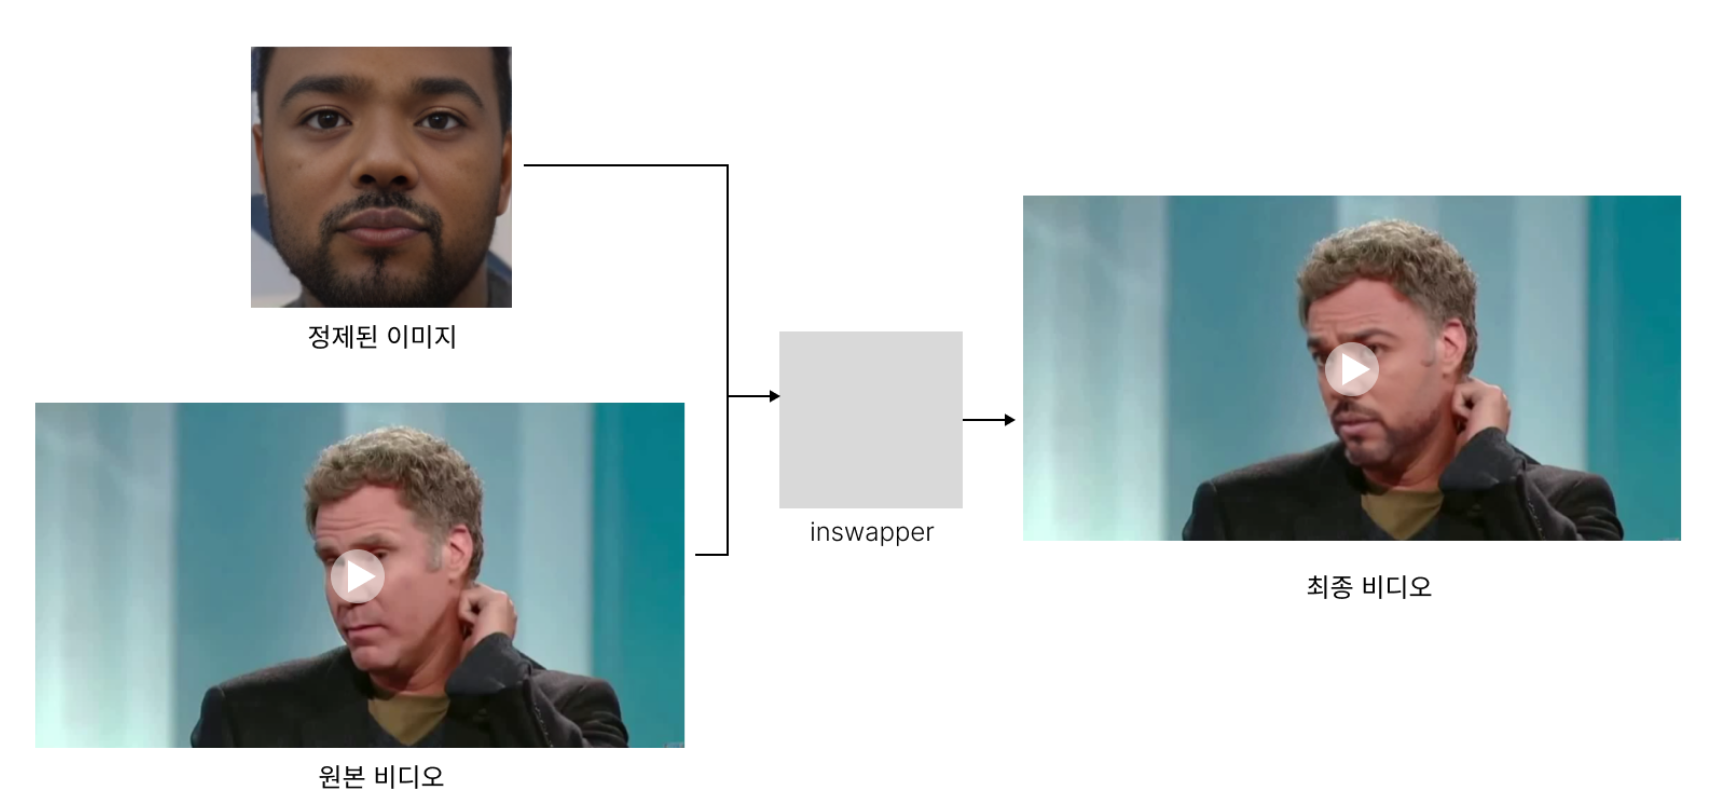

정제된 얼굴 이미지를 이용하여 비디오 속 사람의 얼굴을 실시간으로 교체하고,
원본 비디오의 오디오를 다시 결합하여 최종 비디오를 생성합니다.

In [ ]:
!wget -O inswapper_128.onnx https://huggingface.co/xingren23/comfyflow-models/resolve/main/insightface/inswapper_128.onnx

In [ ]:
!mkdir /kaggle/working/7_inswapper
%cd /kaggle/working/7_inswapper

!wget -O w600k_r50.onnx https://huggingface.co/maze/faceX/resolve/main/w600k_r50.onnx

!wget -O inswapper_128.onnx https://huggingface.co/xingren23/comfyflow-models/resolve/main/insightface/inswapper_128.onnx

!wget -O yoloface_8n.onnx https://huggingface.co/crj/dl-ws/resolve/main/yoloface_8n.onnx

!pip install --upgrade --force-reinstall \
    scipy==1.9.3 \
    scikit-image==0.19.3 \
    insightface==0.7.3 \
    ffmpeg \
    onnxruntime-gpu

# 추가된 패키지 설정 

In [ ]:
!pip uninstall ffmpeg -y
!pip install ffmpeg-python

In [ ]:
import os
os._exit(0)

In [ ]:
%cd /kaggle/working/7_inswapper

로그 제거 버전 

In [ ]:
import os
import cv2
import numpy as np
import ffmpeg
import importlib
import warnings
from pathlib import Path
from tqdm import tqdm
from ultralytics import YOLO
from imageio_ffmpeg import get_ffmpeg_exe

os.environ["KMP_WARNINGS"] = "0"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["ORT_LOG_LEVEL"] = "ERROR"
warnings.filterwarnings("ignore")

model_zoo = importlib.import_module('insightface.model_zoo')
face_align = importlib.import_module('insightface.utils.face_align')

VIDEO_DIR  = Path("/kaggle/input/Deepfake_Detection_and_Generation_Challenge_Red_Team/Source_face_dataset")
GFPGAN_DIR = Path("/kaggle/working/6_GFPGAN_res/restored_imgs")
OUTPUT_DIR = Path("/kaggle/working/7_swapped_videos")
os.makedirs(OUTPUT_DIR, exist_ok=True)
PROVIDERS  = ['CUDAExecutionProvider', 'CPUExecutionProvider']

DET_PATH  = Path("/kaggle/working/7_inswapper/yoloface_8n.onnx")
EMB_PATH  = Path("/kaggle/working/7_inswapper/w600k_r50.onnx")
SWAP_PATH = Path("/kaggle/working/7_inswapper/inswapper_128.onnx")

_YF2SWAP = [0,1,2,3,4]
def init_models(providers):
    det  = YOLO(str(DET_PATH), task="pose")
    emb  = model_zoo.get_model(str(EMB_PATH), providers=providers)
    swap = model_zoo.get_model(str(SWAP_PATH), providers=providers)
    return det, emb, swap

class Face:
    __slots__ = ("bbox","kps","embedding","normed_embedding")
    def __init__(self, bbox, kps, emb):
        self.bbox = np.array(bbox, dtype=np.int32)
        self.kps  = kps.astype(np.float32)
        self.embedding = emb.astype(np.float32)
        n = np.linalg.norm(self.embedding)
        self.normed_embedding = self.embedding / (n if n>0 else 1)

def extract_embedding(emb_model, aligned112):
    if hasattr(emb_model, "get_feat"):
        return emb_model.get_feat(aligned112)
    try:
        return emb_model.get(aligned112)
    except TypeError:
        return emb_model.get(None, aligned112)

def yolo_detect(det_model, frame, conf=0.5):
    res = det_model.predict(frame, verbose=False)[0]
    if res.keypoints is None:
        return []
    h, w = frame.shape[:2]
    faces = []
    for box, kp, score in zip(res.boxes.xyxy.cpu().numpy(),
                               res.keypoints.xyn.cpu().numpy(),
                               res.boxes.conf.cpu().numpy()):
        if score < conf:
            continue
        kp[:,0] *= w; kp[:,1] *= h
        kp = kp[_YF2SWAP]
        faces.append((box.astype(int), kp))
    return faces

def build_face(frame, box, kps, emb_model):
    crop = face_align.norm_crop(frame, kps)
    emb  = extract_embedding(emb_model, crop)
    return Face(box, kps, emb)

def swap_video(video_path, ref_img_path, out_path):
    det, emb_model, swap_model = init_models(PROVIDERS)
    ref_bgr = cv2.imread(str(ref_img_path))
    dets = yolo_detect(det, ref_bgr)
    if not dets:
        return False
    REF = build_face(ref_bgr, *dets[0], emb_model)

    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        return False
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS) or 25
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out_v = cv2.VideoWriter(str(out_path), fourcc, fps, (w, h))

    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for _ in tqdm(range(total), desc=f"Swapping {ref_img_path.name}", leave=False):
        ret, frame = cap.read()
        if not ret:
            break
        dets = yolo_detect(det, frame)
        if dets:
            try:
                tgt = build_face(frame, *dets[0], emb_model)
                frame = swap_model.get(frame, tgt, REF, paste_back=True)
            except:
                pass
        out_v.write(frame)
    cap.release(); out_v.release()
    return True

def mux_audio(video_no_audio, origin_video, out_path):
    ffmpeg_path = get_ffmpeg_exe()
    try:
        probe = ffmpeg.probe(str(origin_video), cmd=ffmpeg_path)
        streams = [s for s in probe['streams'] if s['codec_type'] == 'audio']
        if not streams:
            os.replace(video_no_audio, out_path)
            return
    except:
        os.replace(video_no_audio, out_path)
        return
    video = ffmpeg.input(str(video_no_audio)).video
    audio = ffmpeg.input(str(origin_video)).audio
    (ffmpeg.output(video, audio, str(out_path), vcodec='copy', acodec='aac', strict='experimental')
           .overwrite_output()
           .run(cmd=ffmpeg_path, quiet=True))

if __name__ == '__main__':
    for video_path in sorted(VIDEO_DIR.glob("*.mp4")):
        faceid = video_path.stem
        # if int(faceid) < 20:
        #     continue
        matches = list(GFPGAN_DIR.glob(f"{faceid}_*.png"))
        if not matches:
            continue
        for ref_img in matches:
            no_audio = OUTPUT_DIR / f"{ref_img.stem}_noaudio.mp4"
            final    = OUTPUT_DIR / f"{ref_img.stem}.mp4"
            if swap_video(video_path, ref_img, no_audio):
                mux_audio(no_audio, video_path, final)
    print("모든 처리 완료")


# **Steo 6: 노이즈 추가**

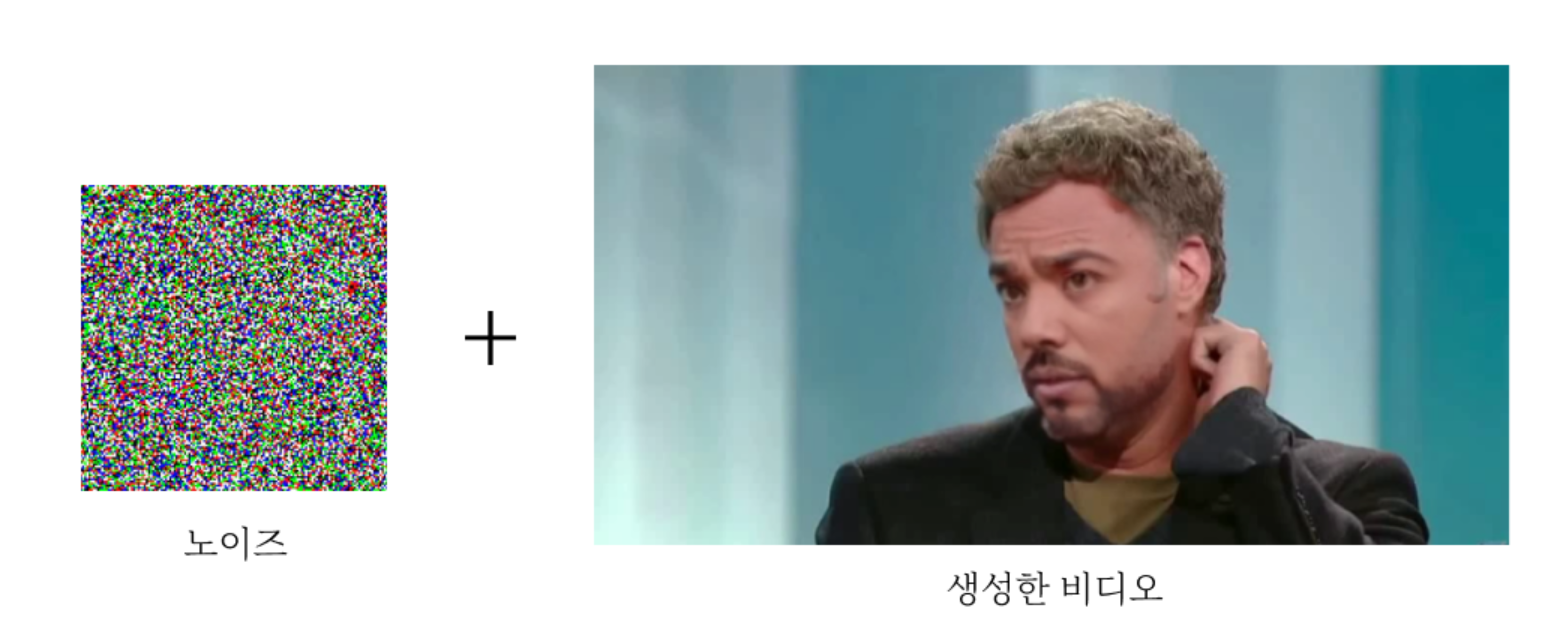

생성된 딥페이크 비디오에 자연스러운 노이즈를 추가하여 딥페이크 검출기를 회피할 수 있도록 한다

In [ ]:

!pip install numpy==1.24.1 opencv_python==4.8.0.76 scikit_learn==1.3.0 scipy==1.11.1 torchattacks==3.4.0 umap==0.1.1
!mkdir -p /kaggle/working/result
import os
os._exit(0)

In [ ]:
import os
from pathlib import Path
import cv2
import torch
import torchvision.transforms as T
import numpy as np
from tqdm import tqdm


class NoiseAttack:
    def __init__(self, step=10, epsilon_n=4./255., noise_lr=1./255., device='cpu'):
        self.step = step
        self.epsilon_n = epsilon_n
        self.noise_lr = noise_lr
        self.device = torch.device(device)

    def __call__(self, image: torch.Tensor):
        image = image.clone().detach().to(self.device)
        noise = torch.zeros_like(image, requires_grad=True)

        for _ in range(self.step):
            pert = (image + noise).clamp(0, 1)
            loss = noise.pow(2).sum()

            grad = torch.autograd.grad(loss, noise, retain_graph=False)[0]

            noise = noise - self.noise_lr * grad.sign()
            noise = noise.clamp_(-self.epsilon_n, self.epsilon_n)
            noise = noise.detach().requires_grad_() 

        pert = (image + noise).clamp(0, 1)
        return pert


in_dir  = Path("/kaggle/working/7_swapped_videos")  
out_dir = Path("/kaggle/working/result")
out_dir.mkdir(parents=True, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
attack = NoiseAttack(step=10, epsilon_n=4/255., noise_lr=1/255., device=device)
to_tensor = T.ToTensor()


mp4_list = sorted([p for p in in_dir.iterdir() if p.suffix.lower() == ".mp4"])
for vid_path in mp4_list:
    print(f"\nProcessing {vid_path.name}")
    cap = cv2.VideoCapture(str(vid_path))

    fps          = cap.get(cv2.CAP_PROP_FPS)
    frame_width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count  = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    out_path = out_dir / vid_path.name
    writer   = cv2.VideoWriter(
        str(out_path),
        cv2.VideoWriter_fourcc(*'mp4v'),
        fps,
        (frame_width, frame_height)
    )

    for _ in tqdm(range(frame_count), leave=False):
        ret, frame = cap.read()
        if not ret:
            break


        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img_tensor = to_tensor(rgb).unsqueeze(0).to(device).requires_grad_()

        pert_tensor = attack(img_tensor).detach().cpu().squeeze(0)
        pert_tensor = torch.clamp(pert_tensor, 0, 1)

        pert_np = (pert_tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        out_bgr = cv2.cvtColor(pert_np, cv2.COLOR_RGB2BGR)

        writer.write(out_bgr)

    cap.release()
    writer.release()
    print(f"Saved to {out_path}")

print("모든 동영상 처리")



In [ ]:
import csv
import re
from pathlib import Path

src_dir     = Path("/kaggle/working/result")
result_dir  = src_dir      
csv_path    = Path("/kaggle/working/submisson.csv")

rows = []

pattern = re.compile(r"^(\d{4})_(\d{4})_(\d{4})_(\d{4})\.mp4$")

for mp4 in sorted(src_dir.glob("*.mp4")):
    m = pattern.match(mp4.name)
    if not m:
        continue 

    face_id, eyes_id, nose_id, mouth_id = m.groups()

    original      = f"{eyes_id}.mp4/{nose_id}.mp4/{mouth_id}.mp4"
    target        = f"{face_id}.mp4"
    manipulation  = str(result_dir / f"{face_id}.mp4")
    description   = (
        "Change the face after combining 4 face parts("
        f"face: {face_id}.mp4, eyes: {eyes_id}.mp4, "
        f"nose: {nose_id}.mp4, mouth: {mouth_id}.mp4)"
    )

    rows.append([original, target, manipulation, description])

csv_path.parent.mkdir(parents=True, exist_ok=True)
with open(csv_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["Original", "Target", "Manipulation", "Description"])
    writer.writerows(rows)

print(f"CSV: {csv_path}")
